# Nanocompore Usage 

## Preparing data 

The 2 matching nanopore datasets have to be basecalled, aligned and resquiggled before the data can be processed by *nanocompore*.  

### Basecalling reads

If using Albacore for basecalling from raw fast5 files, use the *--disable_filtering* to disable filtering of low quality value, as the presence of modifications might bias the read quality.

Example of basecalling of a direct RNA sample with *Albacore v2.3.1*: 

In [ ]:
read_fast5_basecaller.py --disable_filtering -r -f FLO-MIN106 -k SQK-RNA001 -o fastq -q 0 -i ./raw/ -s ./basecall/

### Read alignment

Basecalled reads have to be aligned to a reference. For dRNA-Seq, reads should be aligned to a reference transcriptome (not genome) in a non-spliced fashion. We recommend to filter bam files to remove any reads that would be unmapped, secondary, supplementary (SAM flag 2304). In addtion, if aligning reads on a transcriptome reference, one should also remove reads mapped on the reverse strand (SAM flag 2324). Finally, we recommend to filter out reads with a low alignment score (MAPQ<30). Reads have to be sorted and indexed for Nanopolish.

Example of dRNA-Seq alignment with *Minimap2 v2.11*:

In [ ]:
minimap2 -ax map-ont ./reference/transcriptome.fa ./basecall/workspace/reads.fastq > ./alignment/reads.sam

samtools view ./alignment/reads.sam -bh -F 2324 -q 30 | samtools sort -o ./alignment/reads.bam

samtools index ./alignment/reads.bam

### Event alignment with nanopolish

Nanopolish is required to realign raw signal to the expected reference sequence. Reads have to be indexed first with *nanopolish index*, realigned with *nanopolish eventalign* and finally the data has to be collapsed per kmer and indexed by *NanopolishComp Eventalign_collapse*.

Example of dRNA-Seq alignment with Nanopolish v0.10.1 and NanopolishComp v0.4.3

In [ ]:
nanopolish index -d ./raw/ ./basecall/workspace/reads.fastq

nanopolish eventalign --reads ./basecall/workspace/reads.fastq --bam ./alignment/reads.bam --genome ./reference/transcriptome.fa --samples > ./eventalign/reads.tsv

NanopolishComp Eventalign_collapse -i ./eventalign/reads.tsv -o ./eventalign/reads_collapsed.tsv

## Using Nanocompore Python API

Import package modules  

In [2]:
from nanocompore.Whitelist import Whitelist
from nanocompore.SampComp import SampComp
from nanocompore.SampCompDB import SampCompDB

### Generate a whitelist of transcripts intervals

This step is necessary to narrow down the list of candidate position to check based on a sufficient coverage in both samples. Basically, the method parse the index file and save the information corresponding to revelant reads

The method requires the path of the index file generated by *NanopolishComp Eventalign_collapse* for each of the 2 samples. In addition, it also requires the path of a the fasta index file corresponding to the reference used for the genome/transcriptome alignment. This can be easily generated using samtools faidx.

The following options are also available:
* **min_coverage**: minimal coverage required in both samples
* **downsample_high_coverage**: For reference with higher coverage, downsample by randomly selecting reads.
* **max_NNNNN_kmers_freq**: maximum frequency of NNNNN kmers in reads (1 to deactivate)
* **max_mismatching_kmers_freq**: maximum frequency of mismatching kmers in reads (1 to deactivate)
* **max_missing_kmers_freq**: maximum frequency of missing kmers in reads (1 to deactivate)
* **logLevel**: Set the log level. Valid values: warning, info, debug

In [6]:
w  = Whitelist (
    s1_index_fn = "./data/KO/eventalign_collapsed.tsv.idx",
    s2_index_fn = "./data/WT/eventalign_collapsed.tsv.idx",
    fasta_fn = "./data/Yeast_transcriptome.fa",
    min_coverage=3)

Initialise Whitelist and checks options
Index Fasta file
Read eventalign index files
	References found in index: 167
Filter out references with low coverage
	References remaining after reference coverage filtering: 2
Compute coverage per reference and select intervals with high enough coverage
100%|██████████| 2/2 [00:00<00:00, 211.74 References/s]
	References remaining after position coverage filtering: 2


The list of reference id and valid interval conveniently wrapped in object variables  

In [29]:
w.ref_id_list

['YHR174W', 'YGR192C']

In [30]:
w.interval_dict

defaultdict(list, {'YHR174W': [(0, 1309)], 'YGR192C': [(868, 992)]})

The Whitelist object can be used as an iterator or as a dictionary

In [4]:
w["YGR192C"]

OrderedDict([('interval_list', [(868, 992)]),
             ('S1',
              [line_tuple(ref_id='YGR192C', ref_start=868, ref_end=993, read_id='225', kmers=121, NNNNN_kmers=3, mismatching_kmers=0, missing_kmers=4, byte_offset=8574248, byte_len=4550),
               line_tuple(ref_id='YGR192C', ref_start=824, ref_end=993, read_id='224', kmers=165, NNNNN_kmers=3, mismatching_kmers=0, missing_kmers=4, byte_offset=8578799, byte_len=6147),
               line_tuple(ref_id='YGR192C', ref_start=0, ref_end=993, read_id='223', kmers=942, NNNNN_kmers=35, mismatching_kmers=0, missing_kmers=51, byte_offset=8621325, byte_len=34753)]),
             ('S2',
              [line_tuple(ref_id='YGR192C', ref_start=0, ref_end=995, read_id='220', kmers=961, NNNNN_kmers=25, mismatching_kmers=0, missing_kmers=34, byte_offset=8050252, byte_len=35273),
               line_tuple(ref_id='YGR192C', ref_start=0, ref_end=976, read_id='221', kmers=931, NNNNN_kmers=31, mismatching_kmers=0, missing_kmers=45, byte_of

Finally it can be written as a basic bed file

In [5]:
w.to_bed (bed_fn="./output/whitelist.bed")

### Compare samples with SampComp

SampComp is the main package method. Based on the information contained in the whitelist object, it retrieves the read data and aggregate results per position of each reference sequence. The method requires the path of the data file generated by NanopolishComp Eventalign_collapse for each of the 2 samples. In addition, it also needs a whitelist object as well as a path to right the output result database file.

The following options are also available:

* **padj_threshold**: Adjusted p-value threshold for reporting sites.
* **comparison_method**: Statistical method to compare the 2 samples signal (default kmean)
* **sequence_context**: Extend statistical analysis to contigous adjacent base is available
* **nthreads**: Number of threads (two are used for reading and writing, all the others for processing in parallel).
* **logLevel**: Set the log level. Valid values: warning, info, debug

In [7]:
# Init the object
s = SampComp (
    s1_fn = "./data/KO/eventalign_collapsed.tsv",
    s2_fn = "./data/WT/eventalign_collapsed.tsv",
    output_db_fn = "./output/out.db",
    fasta_fn = "./data/Yeast_transcriptome.fa",
    whitelist = w,
    nthreads = 4)

# Run thr analysis
res = s ()

Initialise SampComp and checks options
Start data processing
 50%|█████     | 1/2 [00:01<00:01,  1.43s/ Processed References]


The whitelist step can be skipped and done directly in SampComp. But in this situation you will not have access to the content of the whitelist and you have to give the fasta index to SampComp

In [5]:
s = SampComp (
    s1_fn = "./data/KO/eventalign_collapsed.tsv",
    s2_fn = "./data/WT/eventalign_collapsed.tsv",
    output_db_fn = "./output/out.db",
    fasta_fn = "./data/Yeast_transcriptome.fa",
    min_coverage=10,
    nthreads = 4,
    downsample_high_coverage=50,
    comparison_method="mann_whitney",
    sequence_context=2)

# Run thr analysis
res = s ()

Initialise SampComp and checks options
Initialise Whitelist and checks options
Index Fasta file
Read eventalign index files
	References found in index: 167
Filter out references with low coverage
	References remaining after reference coverage filtering: 1
Compute coverage per reference and select intervals with high enough coverage
100%|██████████| 1/1 [00:00<00:00, 118.30 References/s]
	References remaining after position coverage filtering: 1
Start data processing
100%|██████████| 1/1 [00:06<00:00,  6.53s/ Processed References]


For the moment SampComp supports kolmogorov_smirnov, mann_whitney and t_test pair comparison

### Explore results

SampComp creates a shelve database containing results for all positions with sufficient coverage. At the end of the run it returns a SampCompDB object wrapping the shelve.

It is also possible to reload the object latter using the db file path. SampCompDB also need a fasta file path to get the corresponding reference id sequence.

SampCompDB provide simple high level function to plot, explore and export the results

In [3]:
# Loading from existing result shelve database
res = SampCompDB (db_fn = "./output/out.db", fasta_fn = "./data/Yeast_transcriptome.fa")
res.ref_id_list

['YHR174W']

Per position data can be accessed using a simple dictionary interface

In [4]:
res ["YHR174W"][824]

OrderedDict([('S1_median',
              array([120.565   , 113.362   , 117.869   , 118.9255  , 119.053   ,
                     119.999   , 116.393   , 119.008   , 117.731   , 117.959   ,
                     119.6815  , 109.576996, 117.103   , 117.565   , 118.172   ,
                     118.649   , 117.3435  , 117.266   , 117.4425  , 118.993   ,
                     116.791   , 116.303   , 118.35    , 118.697   , 113.673   ,
                     118.455   , 117.201   , 117.061   , 121.5815  , 117.231   ,
                     119.597   , 120.9925  , 119.61    , 123.097   , 113.4445  ,
                     117.849   , 117.777   , 115.559494, 117.892   , 118.161   ,
                     117.743   , 119.229   , 117.74    , 119.947   , 120.598   ,
                     117.902   , 118.763504])),
             ('S2_median',
              array([116.994995, 118.59    , 118.288   , 119.395   , 117.274   ,
                     115.047   , 118.277   , 117.677   , 115.933   , 116.393005,
       

P-values can be easily visualized per position using the *plot_pvalue* method

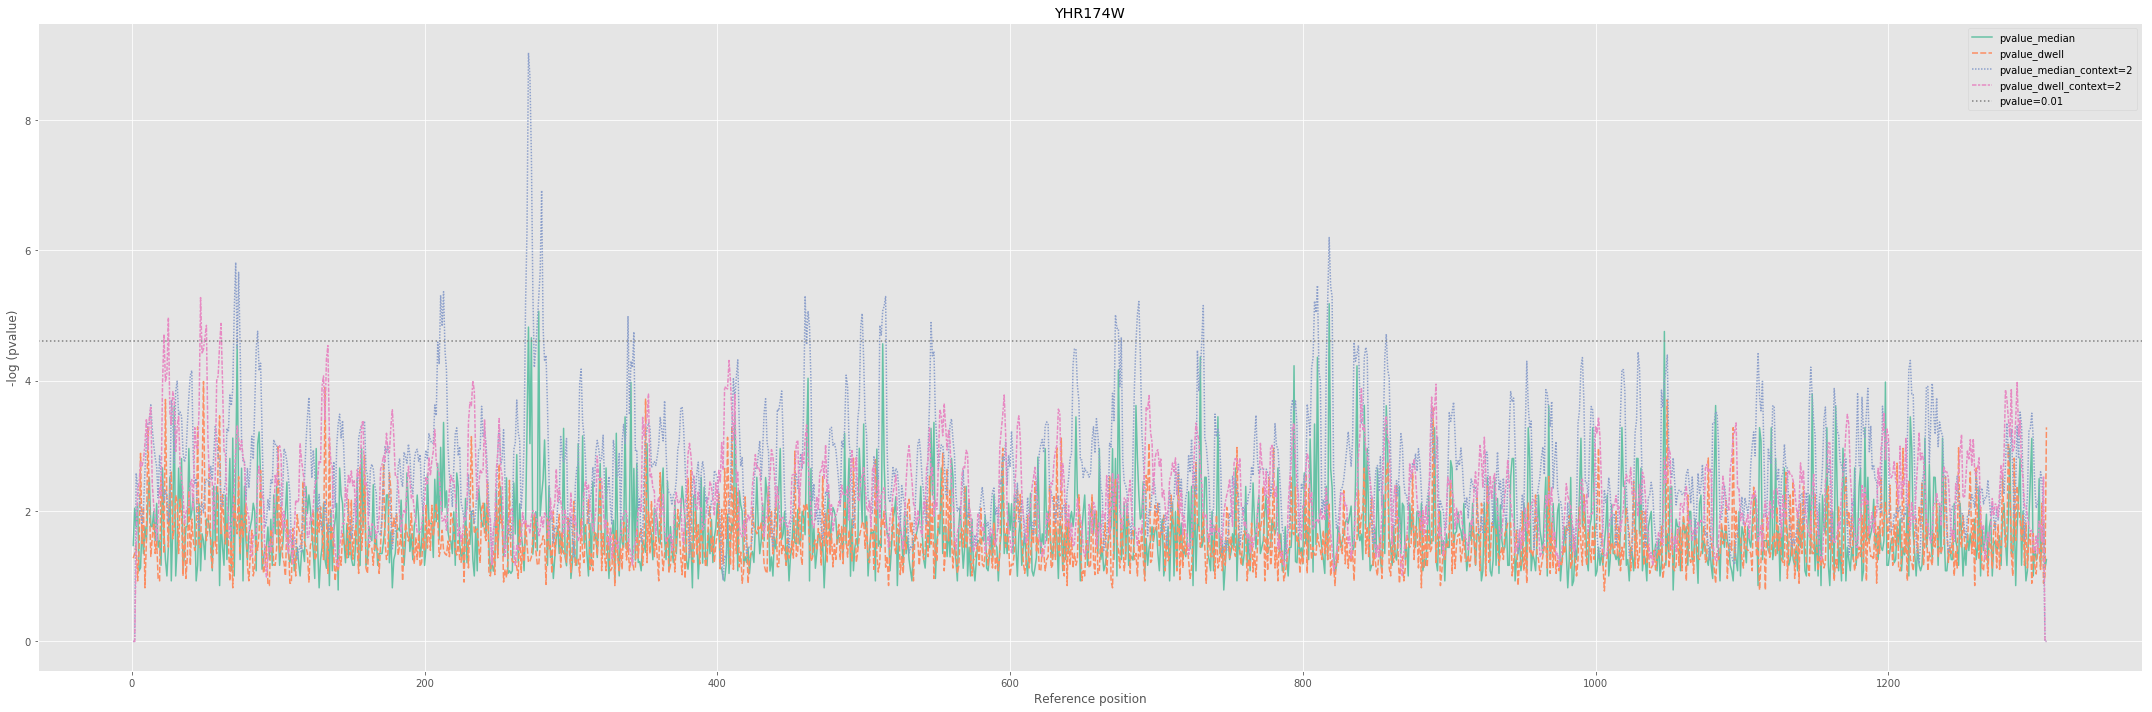

In [5]:
fig, ax = res.plot_pvalue ("YHR174W")

And the original data of the positions of interest can be investigated further with the *plot_signal* method

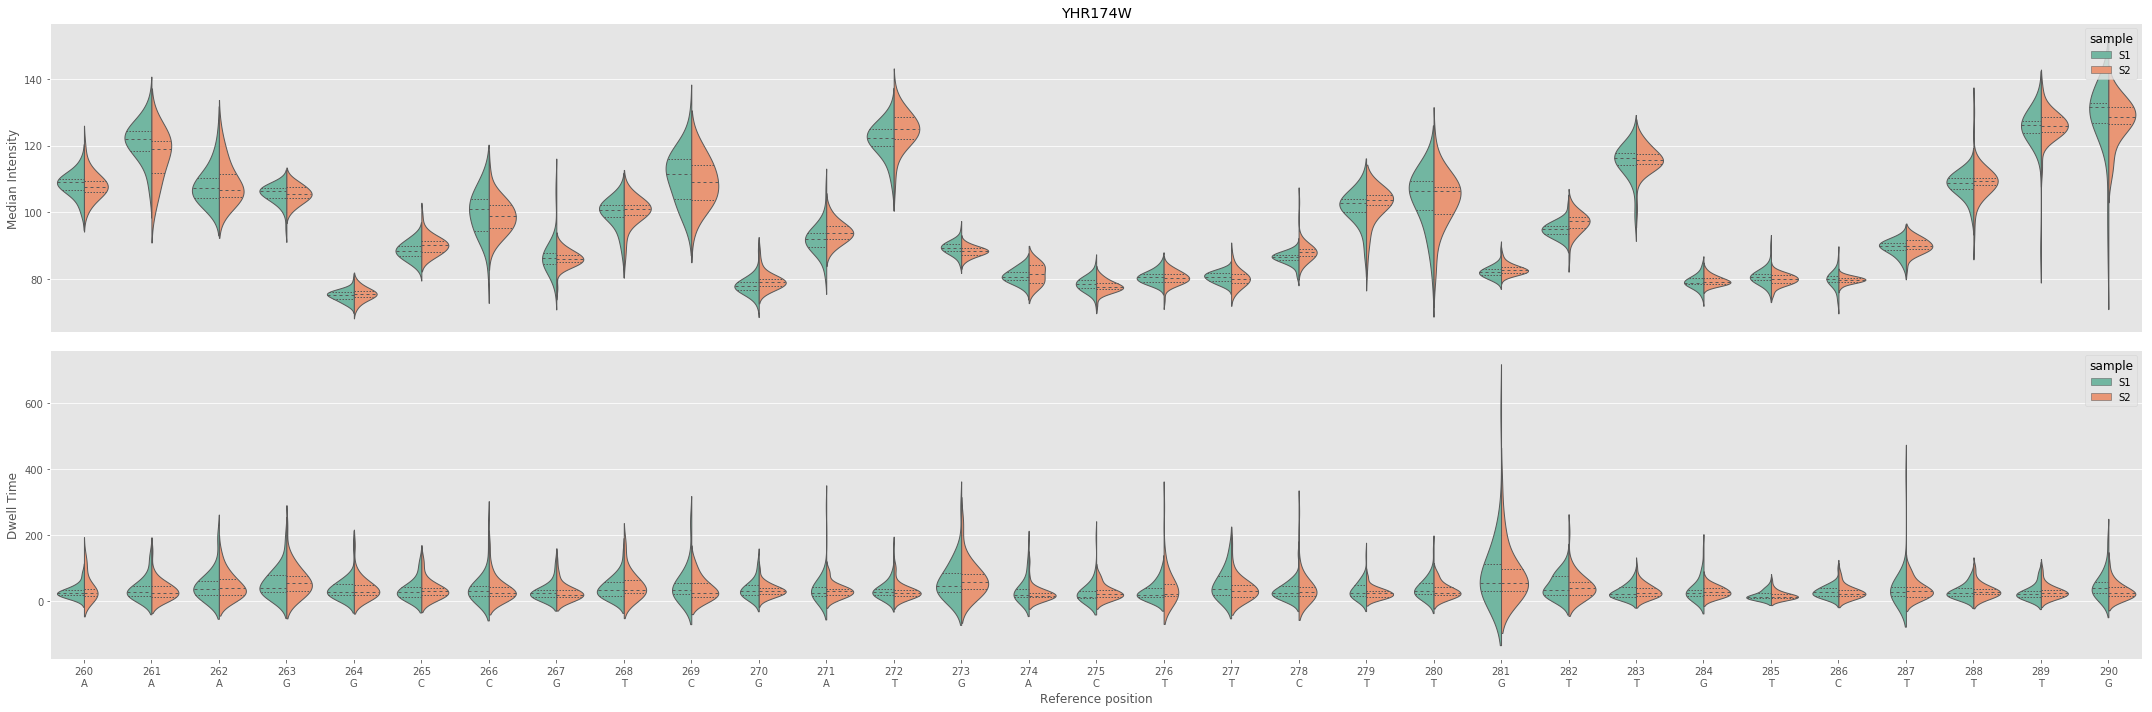

In [8]:
fig, axes = res.plot_signal("YHR174W", start=260, end=290)